**IF MINIMAX+PMCS DOESN'T WORK, JUST USE KIRK2


#### Heuristic todos

NEED TODOS
* increase cutoff depth as board becomes more full DONE(TEST AGAINST PMCS AND SANJAY)
* optimize heuristic wherever possible
* utilize ternary operators
AFTER TESTING DYNAMIC CUTOFF DEPTH
* setup defense mode

POTENTIAL ADD/TRY:
* optimize, set height and width etc
    * ternary operators
* setup defense mode
* increase cutoff depth as board becomes more full
* store board as bits
* alter heuristic

PROCESS
* make search
* test a few moves
* [test against unbeatable site](https://connect4.gamesolver.org/en/)
* test against pmcs

empty board and visualize board helper function

In [1]:
# Visualization code by Randolph Rankin
import matplotlib.pyplot as plt
import numpy as np
import math

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

## minimax + heuristics

### heuristic function
    
* DONE 4 in a row
* 3 in a row
    * DONE move can be made on either side of 3 in row (ex. [0, 1, 1, 1, 0]) WIN - infinity
    * DONE move can be made on only side of 3 in row (ex. [-1, 1, 1, 1, 0]) BIG + - 900k
    * DONE there are 2 with a gap then 1 (ex. [1, 0, 1, 1]) BIG + - 900k
    * DONE move can't be made on either side of 3 in row (ex. [-1, 1, 1, 1,-1]) +0 includes non-immediate moves?
* 2 in a row
    * DONE move can be made on either side of 2 in row (ex. [0, 1, 1, 0]) BIG + - 50k
    * DONE move can be made on only side of 2 in row (ex. [-1, 1, 1, 0]) BIG + - 10k includes non-immediate moves
        * increase for each available square up to 40k
* 1 on its own
    * DONE add small score based on its column position

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

class Kirk_search:
    def __init__(self, board, player, cutoff = 6, debug=2):

        self.player= player
        self.maxRows= len(board)
        self.maxCols= len(board[0])
        self.cutoff = cutoff
        self.count = 0
        self.debug= debug # 1 ... count nodes, 2 ... debug each node
    
    def find_move(self, board):
        """start the search. cutoff = None is minimax search with alpha-beta pruning."""
        self.count = 0

        piece_count=count_chips(board)
        if(piece_count<15):
            self.cutoff=4
        elif(piece_count<31):
            self.cutoff=6
        else:
            self.cutoff=8
        
        value, move = self.max_value_ab(board, -math.inf, +math.inf, 0)

        if self.debug >= 1: print(f"Number of nodes searched (cutoff = {self.cutoff}): {self.count}") 

        return {"move": move, "value": value}

    def max_value_ab(self, state, alpha, beta, depth):
        """player's best move."""
        self.count += 1

        # cut off and terminal test
        v, terminal = self.eval_fun(state, self.player)
        if((self.cutoff is not None and depth >= self.cutoff) or terminal): 
            if(terminal): 
                alpha, beta = v, v
            if self.debug >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
            return v, None

        v, move = -math.inf, None

        # check all possible actions in the state, update alpha and return move with the largest value
        for a in self.actions(state):
            v2, a2 = self.min_value_ab(self.result(state, self.player, a), alpha, beta, depth + 1)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta: return v, move

        return v, move

    def min_value_ab(self, state, alpha, beta, depth):
        """opponent's best response."""
        self.count += 1

        # cut off and terminal test
        v, terminal = self.eval_fun(state, self.player)
        if((self.cutoff is not None and depth >= self.cutoff) or terminal): 
            if(terminal): 
                alpha, beta = v, v
            if self.debug >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
            return v, None

        v, move = +math.inf, None

        # check all possible actions in the state, update beta and return move with the smallest value
        for a in self.actions(state):
            v2, a2 = self.max_value_ab(self.result(state, self.other(self.player), a), alpha, beta, depth + 1)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha: return v, move
        return v, move
    
    #gets non active user
    def other(self, player): 
        if player == 1: return -1
        else: return 1
    
    #returns possible moves using move ordering
    def actions(self,s):
        #get not full columns
        actions = np.where(np.array(s[0])==0)[0].tolist()
        #prioritize center columns
        priority = [1,2,3,4,3,2,1]
        priority = [priority[i] for i in actions]

        return [a for _,a in sorted(zip(priority,actions), reverse=True)]

    #updates board with move
    def result(self, s, p, a):
        #check if column is full
        if(s[0][a] != 0):
            print("Error: Illegal move!")
        #copy board
        board = np.copy(s)
        #find lowest row
        lowestRow=0
        for lowestRow in range(self.maxRows):
            #if player disc is found
            if(board[lowestRow][a]!=0):
                #place player disc one above current disc
                board[lowestRow-1][a]=p
                #return board   
                return board
        #place player disc on lowest row
        board[lowestRow][a]=p
        #return board   
        return board

    #checks if the board is full
    def terminal(self, s):
        #search board and check if it is full
        for i in range(len(s)):
            for j in range(len(s[0])):
                if s[i][j] ==0: return False
        return True

    #checks if a player has won
    def check_win(self, s):
        #copy board
        board = np.copy(s)
        #search board
        for i in range(self.maxRows):
            for j in range(self.maxCols):
                #check vertical
                if not i + 3 >= self.maxRows and board[i][j]  == board[i+1][j] == board[i+2][j] == board[i+3][j] !=0:
                    return board[i][j]
                #check horizontal
                if not j + 3 >= self.maxCols and board[i][j]  == board[i][j+1] == board[i][j+2] == board[i][j+3] !=0:
                    return board[i][j]
                #check diagonal
                if not j + 3 >= self.maxCols and not i + 3 >= self.maxRows and board[i][j] == board[i+1][j + 1] == board[i+2][j + 2] == board[i+3][j + 3] !=0:
                    return board[i][j]
                #check reverse diagonal
                if not j - 3 < 0 and not i + 3 >= self.maxRows and board[i][j] == board[i+1][j - 1] == board[i+2][j - 2] == board[i+3][j - 3] !=0:
                    return board[i][j]
        #return 0 if no winner
        return 0

    #checks for winner/tie/game not over
    def utility(self, s, player = 1):
        #check if either player won
        goal = self.check_win(s)
        if goal == player: return +1 
        if goal == self.other(player): return -1
        #check if board is full
        draw = self.terminal(s)
        if draw: return 0
        #if game is not over
        return None
    
    #checks if the board is full
    def count_chips(self, s):
        counter=0
        #search board and check if it is full
        for i in range(len(s)):
            for j in range(len(s[0])):
                if s[i][j] !=0: counter+=0
        return counter

    def check_alone(self,board, player, r, c):
        #check top left row
        if r>0 and c>0 and board[r-1][c-1]==player:
            return 0
        #check top middle row    
        if r>0 and board[r-1][c]==player:
            return 0
        #check top right row
        if r>0 and not c + 1 >= self.maxCols and board[r-1][c+1]==player:
            return 0
        #check left
        if c>0 and board[r][c-1]==player:
            return 0
        #check right
        if not c + 1 >= self.maxCols and board[r][c+1]==player:
            return 0
        #check bottom left row
        if not r + 1 >= self.maxRows and c>0 and board[r+1][c-1]==player:
            return 0
        #check bottom middle row
        if not r + 1 >= self.maxRows and board[r+1][c]==player:
            return 0
        #check bottom left row
        if not r + 1 >= self.maxRows and  not c + 1 >= self.maxCols and board[r+1][c+1]==player:
            return 0   
        #if alone, return value based on column position
        if c==3: return .000002
        elif c==2 or c==4: return .0000012
        elif c==1 or c==5: return .0000007
        elif c==0 or c==6: return .0000004

    #TODO maybe add scores for more spaces after 2 in a row
    def eval_fun(self, board, player):

        # terminal state? aka 4 in a row
        u = self.utility(board, player)
        if u is not None: return u, True

        score = 0
        #go through board
        for r in range(self.maxRows):
            for c in range(self.maxCols):
    #DIAGONAL CHECK
                #check diagonal for 3 in a row
                if not r + 2 >= self.maxRows and not c + 2 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r+1][c+1], board[r+2][c+2]])
                    #check for 3 in a row for player
                    if sum(row == player) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            return player, False
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and r>0 and board[r-1][c-1]==0):
                            score+=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            score+=.009           
                    #check for 3 in a row for other player       
                    elif sum(row == self.other(player)) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            return self.other(player), False
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and r>0 and board[r-1][c-1]==0):
                            score-=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            score-=.009    
                #check diagonal for 2 in a row
                if not r + 1 >= self.maxRows and not c + 1 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r+1][c+1]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and r>0 and board[r-1][c-1]==player) and not (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==player):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and r>1 and board[r-2][c-2]==player):
                                    score+=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==player):
                                    score+=.009
                                else: score+=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and r>0 and board[r-1][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and r>1 and board[r-2][c-2]==player):
                                    score+=.009
                                else: score+=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==player):
                                    score+=.009
                                else: score+=.0001   
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and r>0 and board[r-1][c-1]==self.other(player)) and not (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==self.other(player)):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and r>1 and board[r-2][c-2]==self.other(player)):
                                    score-=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and r>0 and board[r-1][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and r>1 and board[r-2][c-2]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
    #REVERSE DIAGONAL CHECK
                #check diagonal for 3 in a row
                if not r + 2 >= self.maxRows and c>1:
                    #get row
                    row = np.array([board[r][c], board[r+1][c-1], board[r+2][c-2]])
                    #check for 3 in a row for player
                    if sum(row == player) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            return player, False
                        #check if before 3 is empty [0,1,1,1]
                        elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                            score+=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            score+=.009
                    #check for 3 in a row for other player
                    elif sum(row == self.other(player)) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            return self.other(player), False
                        #check if before 3 is empty [0,1,1,1]
                        elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                            score-=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            score-=.009  
                #check diagonal for 2 in a row
                if not r + 1 >= self.maxRows and c>0:
                    #get row
                    row = np.array([board[r][c], board[r+1][c-1]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==player) and not (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==player):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==player):
                                    score+=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==player):
                                    score+=.009
                                else: score+=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==player):
                                    score+=.009
                                else: score+=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==player):
                                    score+=.009
                                else: score+=.0001  
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==self.other(player)) and not (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==self.other(player)):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==self.other(player)):
                                    score-=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==self.other(player)):
                                    score-=.009
                                else: score-=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
    #VERTICAL CHECK
                #check vertical for 3 in a row
                if not r + 2 >= self.maxRows:
                    #get row
                    row = np.array([board[r][c], board[r+1][c], board[r+2][c]])
                    #check for 3 in a row for player and before 3 is empty [0,1,1,1]
                    if sum(row == player) == 3 and r>0 and board[r-1][c]==0:
                        score+=.009
                    #check for 3 in a row for other player and before 3 is empty [0,1,1,1]
                    elif sum(row == self.other(player)) == 3 and r>0 and board[r-1][c]==0:
                        score-=.009                              
                #check vertical for 2 in a row
                if not r + 1 >= self.maxRows:
                    #get row
                    row = np.array([board[r][c], board[r+1][c]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (r>0 and board[r-1][c]==player) and not (not r + 2 >= self.maxRows and board[r+2][c]==player):
                            #make sure before is empty
                            if r>0 and board[r-1][c]==0:
                                score+=.0001
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (r>0 and board[r-1][c]==self.other(player)) and not (not r + 2 >= self.maxRows and board[r+2][c]==self.other(player)):
                            #make sure before is empty
                            if r>0 and board[r-1][c]==0:
                                score-=.0001
    #HORIZONTAL CHECK
                #check horizontal for 3 in a row
                if not c + 2 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r][c+1], board[r][c+2]])
                    #check for 3 in a row for player
                    if sum(row == player) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and board[r][c-1]==0) and (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            return player, False
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and board[r][c-1]==0):
                            score+=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            score+=.009           
                    #check for 3 in a row for other player       
                    elif sum(row == self.other(player)) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and board[r][c-1]==0) and (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            return self.other(player), False
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and board[r][c-1]==0):
                            score-=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            score-=.009          
                #check horizontal for 2 in a row
                if not c + 1 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r][c+1]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and board[r][c-1]==player) and not (not c + 2 >= self.maxCols and board[r][c+2]==player):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and board[r][c-1]==0) and (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and board[r][c-2]==player):
                                    score+=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and board[r][c+3]==player):
                                    score+=.009
                                else: score+=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and board[r][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and board[r][c-2]==player):
                                    score+=.009
                                else: score+=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and board[r][c+3]==player):
                                    score+=.009
                                else: score+=.0001           
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and board[r][c-1]==self.other(player)) and not (not c + 2 >= self.maxCols and board[r][c+2]==self.other(player)):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and board[r][c-1]==0) and (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and board[r][c-2]==self.other(player)):
                                    score-=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and board[r][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and board[r][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and board[r][c-2]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and board[r][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
    #ALONE CHECK
                #check if square is not connected
                if board[r][c]!=0:
                    score+=self.check_alone(board, player, r, c)
                    score-=self.check_alone(board, self.other(player), r, c)
        #return final score
        return score, False

In [3]:
def kirk_player(board, player = 1, cutoff=6, debug=0):
    heuristic_player=Kirk_search(board=board, player=player, cutoff=cutoff, debug=debug)
    return heuristic_player.find_move(board)

## Testing

### first move

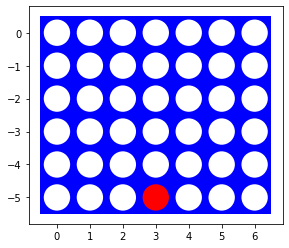

{'move': 4, 'value': 0.0002}

CPU times: total: 10 s
Wall time: 10 s


In [5]:
board = [[ 0, 0, 0, 0, 0, 0, 0],
         [ 0, 0, 0, 0, 0, 0, 0],
         [ 0, 0, 0, 0, 0, 0, 0],
         [ 0, 0, 0, 0, 0, 0, 0],
         [ 0, 0, 0, 0, 0, 0, 0],
         [ 0, 0, 0, 1, 0, 0, 0]]

visualize(board)
%time display(kirk_player(board))

# MCTS Restricted

In [6]:
class PMCSR:
    def __init__(self, player, N=10, debug=2):
        self.player= player
        self.N = N
        self.debug= debug

    def find_move(self, board):
        """Upper Confidence bound applied to Trees for limited tree depth of 1. 
        Simulation budget is N playouts."""
        C = math.sqrt(2) # tradeoff constant

        # the tree is 1 action deep
        acts = self.actions(board)

        u = [0] * len(acts) # total utility through actions
        n = [0] * len(acts) # number of playouts through actions
        n_parent = 0 # total playouts so far (i.e., number of playouts through parent)

        # make sure we try each action once
        UCB1 = [+math.inf] * len(acts) 

        for i in range(self.N):

            # Select
            action_id = UCB1.index(max(UCB1))

            # Expand
            # UTC would expand the tree. We keep the tree at depth 1, essentially performing
            # Pure Monte Carlo search with an added UCB1 selection policy. 

            # Simulate
            p = self.playout(board, acts[action_id])

            # Back-Propagate (i.e., update counts and UCB1)
            u[action_id] += p
            n[action_id] += 1
            n_parent += 1

            for action_id in range(len(acts)):
                if n[action_id] > 0:
                    UCB1[action_id] = u[action_id] / n[action_id] + C * math.sqrt(math.log(n_parent) / n[action_id])

        # return action with largest number of playouts 
        action = acts[n.index(max(n))]

        if self.debug >= 1: 
            print(pd.DataFrame({'action':acts, 
                                'total utility':u, 
                                '# of playouts':n, 
                                'UCB1':UCB1}))
            print()
            print(f"Best action: {action}")

        return {"move": action}
        
    def playout(self, state, action):
        """Perfrom a random playout starting with the given action on the fiven board 
        and return the utility of the finished game."""
        state = self.result(state, self.player, action)
        current_player = self.other(self.player)

        while(True):
            # reached terminal state?
            u = self.utility(state, self.player)
            if u is not None: return u

            # we use a random playout policy
            a = np.random.choice(self.actions(state))
            state = self.result(state, current_player, a)
            #print(state)

            # switch between players
            current_player = self.other(current_player)     
            
    #updates board with move
    def result(self, s, p, a):
        #check if column is full
        if(s[0][a] != 0):
            print("Error: Illegal move!")
        #copy board
        board = np.copy(s)
        #find lowest row
        lowestRow=0
        for lowestRow in range(len(board)):
            #if player disc is found
            if(board[lowestRow][a]!=0):
                #place player disc one above current disc
                board[lowestRow-1][a]=p
                #return board   
                return board
        #place player disc on lowest row
        board[lowestRow][a]=p
        #return board   
        return board

    #checks if a player has won
    def check_win(self, s):
        #copy board
        board = np.copy(s)
        #search board
        for i in range(len(board)):
            for j in range(len(board[0])):
                #check vertical
                if not i + 3 >= len(board) and board[i][j]  == board[i+1][j] == board[i+2][j] == board[i+3][j] !=0:
                    return board[i][j]
                #check horizontal
                if not j + 3 >= len(board[0]) and board[i][j]  == board[i][j+1] == board[i][j+2] == board[i][j+3] !=0:
                    return board[i][j]
                #check diagonal
                if not j + 3 >= len(board[0]) and not i + 3 >= len(board) and board[i][j] == board[i+1][j + 1] == board[i+2][j + 2] == board[i+3][j + 3] !=0:
                    return board[i][j]
                #check reverse diagonal
                if not j - 3 < 0 and not i + 3 >= len(board)and board[i][j] == board[i+1][j - 1] == board[i+2][j - 2] == board[i+3][j - 3] !=0:
                    return board[i][j]
        #return 0 if no winner
        return 0

    #checks for winner/tie/game not over
    def utility(self, s, player = 1):
        #check if either player won
        goal = self.check_win(s)
        if goal == player: return +1 
        if goal == self.other(player): return -1
        #check if board is full
        draw = self.terminal(s)
        if draw: return 0
        #if game is not over
        return None

    #checks if the board is full
    def terminal(self, s):
        #search board and check if it is full
        for i in range(len(s)):
            for j in range(len(s[0])):
                if s[i][j] ==0: return False
        return True

    #returns possible moves using move ordering
    def actions(self, s):
        #get not full collumns
        actions = np.where(np.array(s[0])==0)[0].tolist()
        #prioritize center columns
        priority = [1,2,3,4,3,2,1]
        priority = [priority[i] for i in actions]

        return [a for _,a in sorted(zip(priority,actions), reverse=True)]
    
    #gets non active user
    def other(self, player): 
        if player == 1: return -1
        else: return 1

In [7]:
def pmcsr_player(board, player = 1, N=100, debug=0):
    pmcsr_play=PMCSR(player=player, N=N, debug=debug)
    return pmcsr_play.find_move(board)

# PMCS

In [14]:
class PMCS:
    def __init__(self, player, N=10, debug=2):
        self.player= player
        self.N = N
        self.debug= debug

    def find_move(self, board):
        """Pure Monte Carlo Search. Returns the action that has the largest average utility.
        The N playouts are evenly divided between the possible actions."""

        acts = self.actions(board)
        n = math.floor(self.N/len(acts))
        if self.debug >= 1: print(f"Actions: {acts} ({n} playouts per action)")

        ps = { i : np.mean(self.playouts(board, i)) for i in acts }
        if self.debug >= 1: display(ps)

        action = max(ps, key=ps.get)
        return {"move": action}
    
    def playouts(self, board, action):
        """Perform N playouts following the given action for the given board."""
        return [ self.playout(board, action) for i in range(self.N) ]
    
    def playout(self, state, action):
        """Perfrom a random playout starting with the given action on the given board 
        and return the utility of the finished game."""
        state = self.result(state, self.player, action)
        current_player = self.other(self.player)

        while(True):
            # reached terminal state?
            u = self.utility(state, self.player)
            if u is not None: return(u)

            # we use a random playout policy
            a = np.random.choice(self.actions(state))
            for action in self.actions(state):
                if self.eval_fun(self.result(state, current_player, action), current_player)>self.eval_fun(self.result(state, current_player, a), current_player):
                    a=action
            
            state = self.result(state, current_player, a)
            #print(state)

            # switch between players
            current_player = self.other(current_player)       
            
    #updates board with move
    def result(self, s, p, a):
        #check if column is full
        if(s[0][a] != 0):
            print("Error: Illegal move!")
        #copy board
        board = np.copy(s)
        #find lowest row
        lowestRow=0
        for lowestRow in range(len(board)):
            #if player disc is found
            if(board[lowestRow][a]!=0):
                #place player disc one above current disc
                board[lowestRow-1][a]=p
                #return board   
                return board
        #place player disc on lowest row
        board[lowestRow][a]=p
        #return board   
        return board

    #checks if a player has won
    def check_win(self, s):
        #copy board
        board = np.copy(s)
        #search board
        for i in range(len(board)):
            for j in range(len(board[0])):
                #check vertical
                if not i + 3 >= len(board) and board[i][j]  == board[i+1][j] == board[i+2][j] == board[i+3][j] !=0:
                    return board[i][j]
                #check horizontal
                if not j + 3 >= len(board[0]) and board[i][j]  == board[i][j+1] == board[i][j+2] == board[i][j+3] !=0:
                    return board[i][j]
                #check diagonal
                if not j + 3 >= len(board[0]) and not i + 3 >= len(board) and board[i][j] == board[i+1][j + 1] == board[i+2][j + 2] == board[i+3][j + 3] !=0:
                    return board[i][j]
                #check reverse diagonal
                if not j - 3 < 0 and not i + 3 >= len(board)and board[i][j] == board[i+1][j - 1] == board[i+2][j - 2] == board[i+3][j - 3] !=0:
                    return board[i][j]
        #return 0 if no winner
        return 0

    #checks for winner/tie/game not over
    def utility(self, s, player = 1):
        #check if either player won
        goal = self.check_win(s)
        if goal == player: return +1 
        if goal == self.other(player): return -1
        #check if board is full
        draw = self.terminal(s)
        if draw: return 0
        #if game is not over
        return None

    #checks if the board is full
    def terminal(self, s):
        #search board and check if it is full
        for i in range(len(s)):
            for j in range(len(s[0])):
                if s[i][j] ==0: return False
        return True

    #returns possible moves using move ordering
    def actions(self, s):
        #get not full collumns
        actions = np.where(np.array(s[0])==0)[0].tolist()
        #prioritize center columns
        priority = [1,2,3,4,3,2,1]
        priority = [priority[i] for i in actions]

        return [a for _,a in sorted(zip(priority,actions), reverse=True)]
    
    #gets non active user
    def other(self, player): 
        if player == 1: return -1
        else: return 1
        
    #TODO maybe add scores for more spaces after 2 in a row
    def eval_fun(self, board, player):

        # terminal state? aka 4 in a row
        u = self.utility(board, player)
        if u is not None: return u

        score = 0
        #go through board
        for r in range(self.maxRows):
            for c in range(self.maxCols):
    #DIAGONAL CHECK
                #check diagonal for 3 in a row
                if not r + 2 >= self.maxRows and not c + 2 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r+1][c+1], board[r+2][c+2]])
                    #check for 3 in a row for player
                    if sum(row == player) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            return player
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and r>0 and board[r-1][c-1]==0):
                            score+=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            score+=.009           
                    #check for 3 in a row for other player       
                    elif sum(row == self.other(player)) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            return self.other(player)
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and r>0 and board[r-1][c-1]==0):
                            score-=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            score-=.009    
                #check diagonal for 2 in a row
                if not r + 1 >= self.maxRows and not c + 1 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r+1][c+1]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and r>0 and board[r-1][c-1]==player) and not (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==player):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and r>1 and board[r-2][c-2]==player):
                                    score+=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==player):
                                    score+=.009
                                else: score+=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and r>0 and board[r-1][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and r>1 and board[r-2][c-2]==player):
                                    score+=.009
                                else: score+=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==player):
                                    score+=.009
                                else: score+=.0001   
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and r>0 and board[r-1][c-1]==self.other(player)) and not (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==self.other(player)):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and r>1 and board[r-2][c-2]==self.other(player)):
                                    score-=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and r>0 and board[r-1][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and r>1 and board[r-2][c-2]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
    #REVERSE DIAGONAL CHECK
                #check diagonal for 3 in a row
                if not r + 2 >= self.maxRows and c>1:
                    #get row
                    row = np.array([board[r][c], board[r+1][c-1], board[r+2][c-2]])
                    #check for 3 in a row for player
                    if sum(row == player) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            return player
                        #check if before 3 is empty [0,1,1,1]
                        elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                            score+=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            score+=.009
                    #check for 3 in a row for other player
                    elif sum(row == self.other(player)) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            return self.other(player)
                        #check if before 3 is empty [0,1,1,1]
                        elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                            score-=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            score-=.009  
                #check diagonal for 2 in a row
                if not r + 1 >= self.maxRows and c>0:
                    #get row
                    row = np.array([board[r][c], board[r+1][c-1]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==player) and not (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==player):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==player):
                                    score+=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==player):
                                    score+=.009
                                else: score+=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==player):
                                    score+=.009
                                else: score+=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==player):
                                    score+=.009
                                else: score+=.0001  
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==self.other(player)) and not (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==self.other(player)):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==self.other(player)):
                                    score-=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==self.other(player)):
                                    score-=.009
                                else: score-=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
    #VERTICAL CHECK
                #check vertical for 3 in a row
                if not r + 2 >= self.maxRows:
                    #get row
                    row = np.array([board[r][c], board[r+1][c], board[r+2][c]])
                    #check for 3 in a row for player and before 3 is empty [0,1,1,1]
                    if sum(row == player) == 3 and r>0 and board[r-1][c]==0:
                        score+=.009
                    #check for 3 in a row for other player and before 3 is empty [0,1,1,1]
                    elif sum(row == self.other(player)) == 3 and r>0 and board[r-1][c]==0:
                        score-=.009                              
                #check vertical for 2 in a row
                if not r + 1 >= self.maxRows:
                    #get row
                    row = np.array([board[r][c], board[r+1][c]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (r>0 and board[r-1][c]==player) and not (not r + 2 >= self.maxRows and board[r+2][c]==player):
                            #make sure before is empty
                            if r>0 and board[r-1][c]==0:
                                score+=.0001
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (r>0 and board[r-1][c]==self.other(player)) and not (not r + 2 >= self.maxRows and board[r+2][c]==self.other(player)):
                            #make sure before is empty
                            if r>0 and board[r-1][c]==0:
                                score-=.0001
    #HORIZONTAL CHECK
                #check horizontal for 3 in a row
                if not c + 2 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r][c+1], board[r][c+2]])
                    #check for 3 in a row for player
                    if sum(row == player) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and board[r][c-1]==0) and (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            return player
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and board[r][c-1]==0):
                            score+=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            score+=.009           
                    #check for 3 in a row for other player       
                    elif sum(row == self.other(player)) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and board[r][c-1]==0) and (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            return self.other(player)
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and board[r][c-1]==0):
                            score-=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            score-=.009          
                #check horizontal for 2 in a row
                if not c + 1 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r][c+1]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and board[r][c-1]==player) and not (not c + 2 >= self.maxCols and board[r][c+2]==player):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and board[r][c-1]==0) and (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and board[r][c-2]==player):
                                    score+=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and board[r][c+3]==player):
                                    score+=.009
                                else: score+=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and board[r][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and board[r][c-2]==player):
                                    score+=.009
                                else: score+=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and board[r][c+3]==player):
                                    score+=.009
                                else: score+=.0001           
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and board[r][c-1]==self.other(player)) and not (not c + 2 >= self.maxCols and board[r][c+2]==self.other(player)):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and board[r][c-1]==0) and (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and board[r][c-2]==self.other(player)):
                                    score-=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and board[r][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and board[r][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and board[r][c-2]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and board[r][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
    #ALONE CHECK
                #check if square is not connected
                if board[r][c]!=0:
                    score+=self.check_alone(board, player, r, c)
                    score-=self.check_alone(board, self.other(player), r, c)
        #return final score
        return score

In [15]:
def pmcs_player(board, player = 1, N=1000, debug=0):
    pmcs_play=PMCS(player=player, N=N, debug=debug)
    return pmcs_play.find_move(board)

In [ ]:
### minimax using pmcs as heuristic

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

class Kirk3_search:
    def __init__(self, board, player, cutoff = 6, debug=2):

        self.player= player
        self.maxRows= len(board)
        self.maxCols= len(board[0])
        self.cutoff = cutoff
        self.count = 0
        self.debug= debug # 1 ... count nodes, 2 ... debug each node
    
    def find_move(self, board):
        """start the search. cutoff = None is minimax search with alpha-beta pruning."""
        self.count = 0

        piece_count=count_chips(board)
        if(piece_count<15):
            self.cutoff=4
        elif(piece_count<31):
            self.cutoff=6
        else:
            self.cutoff=8
        
        value, move = self.max_value_ab(board, -math.inf, +math.inf, 0)

        if self.debug >= 1: print(f"Number of nodes searched (cutoff = {self.cutoff}): {self.count}") 

        return {"move": move, "value": value}

    def max_value_ab(self, state, alpha, beta, depth):
        """player's best move."""
        self.count += 1

        # cut off and terminal test
        v, terminal = self.eval_fun(state, self.player)
        if((self.cutoff is not None and depth >= self.cutoff) or terminal): 
            if(terminal): 
                alpha, beta = v, v
            if self.debug >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
            return v, None

        v, move = -math.inf, None

        # check all possible actions in the state, update alpha and return move with the largest value
        for a in self.actions(state):
            v2, a2 = self.min_value_ab(self.result(state, self.player, a), alpha, beta, depth + 1)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta: return v, move

        return v, move

    def min_value_ab(self, state, alpha, beta, depth):
        """opponent's best response."""
        self.count += 1

        # cut off and terminal test
        v, terminal = self.eval_fun(state, self.player)
        if((self.cutoff is not None and depth >= self.cutoff) or terminal): 
            if(terminal): 
                alpha, beta = v, v
            if self.debug >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
            return v, None

        v, move = +math.inf, None

        # check all possible actions in the state, update beta and return move with the smallest value
        for a in self.actions(state):
            v2, a2 = self.max_value_ab(self.result(state, self.other(self.player), a), alpha, beta, depth + 1)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha: return v, move
        return v, move
    
    #gets non active user
    def other(self, player): 
        if player == 1: return -1
        else: return 1
    
    #returns possible moves using move ordering
    def actions(self,s):
        #get not full columns
        actions = np.where(np.array(s[0])==0)[0].tolist()
        #prioritize center columns
        priority = [1,2,3,4,3,2,1]
        priority = [priority[i] for i in actions]

        return [a for _,a in sorted(zip(priority,actions), reverse=True)]

    #updates board with move
    def result(self, s, p, a):
        #check if column is full
        if(s[0][a] != 0):
            print("Error: Illegal move!")
        #copy board
        board = np.copy(s)
        #find lowest row
        lowestRow=0
        for lowestRow in range(self.maxRows):
            #if player disc is found
            if(board[lowestRow][a]!=0):
                #place player disc one above current disc
                board[lowestRow-1][a]=p
                #return board   
                return board
        #place player disc on lowest row
        board[lowestRow][a]=p
        #return board   
        return board

    #checks if the board is full
    def terminal(self, s):
        #search board and check if it is full
        for i in range(len(s)):
            for j in range(len(s[0])):
                if s[i][j] ==0: return False
        return True

    #checks if a player has won
    def check_win(self, s):
        #copy board
        board = np.copy(s)
        #search board
        for i in range(self.maxRows):
            for j in range(self.maxCols):
                #check vertical
                if not i + 3 >= self.maxRows and board[i][j]  == board[i+1][j] == board[i+2][j] == board[i+3][j] !=0:
                    return board[i][j]
                #check horizontal
                if not j + 3 >= self.maxCols and board[i][j]  == board[i][j+1] == board[i][j+2] == board[i][j+3] !=0:
                    return board[i][j]
                #check diagonal
                if not j + 3 >= self.maxCols and not i + 3 >= self.maxRows and board[i][j] == board[i+1][j + 1] == board[i+2][j + 2] == board[i+3][j + 3] !=0:
                    return board[i][j]
                #check reverse diagonal
                if not j - 3 < 0 and not i + 3 >= self.maxRows and board[i][j] == board[i+1][j - 1] == board[i+2][j - 2] == board[i+3][j - 3] !=0:
                    return board[i][j]
        #return 0 if no winner
        return 0

    #checks for winner/tie/game not over
    def utility(self, s, player = 1):
        #check if either player won
        goal = self.check_win(s)
        if goal == player: return +1 
        if goal == self.other(player): return -1
        #check if board is full
        draw = self.terminal(s)
        if draw: return 0
        #if game is not over
        return None
    
    #checks if the board is full
    def count_chips(self, s):
        counter=0
        #search board and check if it is full
        for i in range(len(s)):
            for j in range(len(s[0])):
                if s[i][j] !=0: counter+=0
        return counter
    
    def eval_fun(self, s):


In [ ]:
def kirk3_player(board, player = 1, cutoff=6, debug=0):
    heuristic_player=Kirk3_search(board=board, player=player, cutoff=cutoff, debug=debug)
    return heuristic_player.find_move(board)